# **Advanced Embedding Methods for Pytorch Forum**


# Get the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/PytorchCommunityData.csv')
data.head()

,Unnamed: 0,Topic Title,Category,Tags,Leading Post,Post Replies,Created_at,Likes,Views,Replies
0,113,About the audio category,audio,[],(Replace this first paragraph with a brief des...,['It would be nice to have some links or somet...,3/15/2018 8:35,0,643,2
1,114,Error while importing torchaudio,audio,[],\n Bug\nI’m getting this error:\nAttributeErro...,[],0,0,0,0
2,115,How do I know which spectrogram frames belong ...,audio,[],I’ve been using this script:\nspgram = torchau...,[],0,0,0,0
3,116,Constant/Variable Q Transform,audio,[],"Hi,\nI’ve been looking into using a Constant Q...",[],0,0,0,0
4,117,Invalid argument 0: Sizes of tensors must matc...,audio,[],"Hello, I am trying to train a speech enhanceme...",['These shape errors are often created for odd...,07-06-21 10:13,0,29,1


# **Explore the data**

In [ ]:

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
#from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = data.copy()

In [ ]:
df.isnull().sum()

Unnamed: 0         0
Topic Title        0
Category           0
Tags            2000
Leading Post       1
Post Replies       0
Created_at        17
Likes             17
Views             17
Replies           17
dtype: int64

In the data of 6000+ posts 2000 posts have missing tags which clearly indicates the categorisation based on tags is missing.

In [ ]:
df["Tags"].fillna("[]", inplace = True)

In [ ]:
df["Leading Post"].fillna("", inplace = True)

In [ ]:
df['post'] = df['Topic Title'] + ' ' + ' ' + df['Post Replies'] + df['Leading Post']
df['post'].head()

0    About the audio category  ['It would be nice t...
1    Error while importing torchaudio  []\n Bug\nI’...
2    How do I know which spectrogram frames belong ...
3    Constant/Variable Q Transform  []Hi,\nI’ve bee...
4    Invalid argument 0: Sizes of tensors must matc...
Name: post, dtype: object

In [ ]:
df['Category'].unique()

array(['audio', 'projects', 'complex', 'ignite', 'C++', 'nlp',
       'distributed', 'jit', 'reinforcement-learning', 'Mobile',
       'quantization', 'deployment', 'uncategorized', 'vision',
       'autograd'], dtype=object)

Text(0, 0.5, 'no of posts')

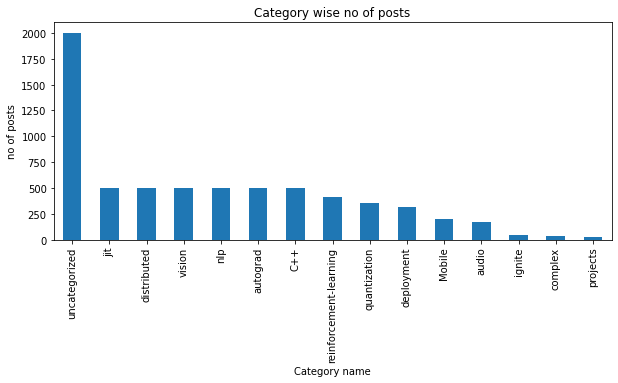

In [ ]:
my_categories = ['audio', 'projects', 'complex', 'ignite', 'C++', 'nlp',
       'distributed', 'jit', 'reinforcement-learning', 'Mobile',
       'quantization', 'deployment', 'uncategorized', 'vision',
       'autograd']
plt.figure(figsize=(10,4))
df.Category.value_counts().plot(kind='bar');
# Add title and axis names
plt.title('Category wise no of posts')
plt.xlabel('Category name')
plt.ylabel('no of posts')

Around 2000 posts are uncategorised which might lead to bias in the results.

In [ ]:
test_df = df.copy()

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #text = ''.join(word for word in text if word not in punct)  # remove punctuation
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
test_df['post'] = test_df['post'].apply(clean_text)

In [ ]:
df_x = test_df['post']
df_y = test_df['Category']

# **Building the Machine Learning model & pipeline**

**Converting to Doc2Vec**

In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))

In [ ]:
doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(df_x).transform(df_x)
doc2vec_features

100%|██████████| 6560/6560 [00:00<00:00, 1439802.94it/s]


matrix([[ 0.00165342,  0.00125994,  0.00014344, ...,  0.00098689,
          0.00309602,  0.00174881],
        [ 0.00294365, -0.00349063,  0.00092414, ...,  0.00470387,
         -0.00158914,  0.0028826 ],
        [-0.00122409,  0.00271758, -0.00197222, ...,  0.00376871,
          0.001567  , -0.0022454 ],
        ...,
        [-0.00310982,  0.00086614, -0.00454578, ...,  0.00217033,
          0.00479208, -0.003804  ],
        [ 0.03349808,  0.02229475,  0.00183609, ..., -0.02224257,
          0.00054991,  0.05254572],
        [-0.0062665 ,  0.00465432, -0.00530614, ...,  0.00299963,
         -0.00420759, -0.0109519 ]], dtype=float32)

# **Pipeline with Doc2Vec & LogisticRegression**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pl_log_reg = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())
score1 = sccores.mean();

100%|██████████| 5248/5248 [00:00<00:00, 1842138.04it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 5248/5248 [00:00<00:00, 1433520.51it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 5248/5248 [00:00<00:00, 1596786.90it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 5248/5248 [00:00<00:00, 1064395.91it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did n

Accuracy for Logistic Regression:  0.30320121951219514


# **Pipeline with Doc2Vec & RandomForest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pl_random_forest = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

100%|██████████| 5248/5248 [00:00<00:00, 1275523.40it/s]


Accuracy for RandomForest :  0.29878048780487804


# **Pipeline with Doc2Vec & XGBoost**

In [ ]:
import xgboost as xgb

pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, df_x, df_y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())

100%|██████████| 5248/5248 [00:00<00:00, 922961.44it/s]


Accuracy for XGBoost Classifier :  0.2978658536585366


# **Converting to Tf-Idf**

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [ ]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)

In [ ]:
tfidf_vectors.shape

(6560, 92687)

In [ ]:
print(tfidf_vectors)

  (0, 91940)	0.027908960498276254
  (0, 91936)	0.019734138139871366
  (0, 90782)	0.028012940052339813
  (0, 90610)	0.05657815833234187
  (0, 90528)	0.04000136254025938
  (0, 90446)	0.030519654077069337
  (0, 90398)	0.03876337774383096
  (0, 90310)	0.055752551073917515
  (0, 90041)	0.10705475518156729
  (0, 88330)	0.06554164394526742
  (0, 88177)	0.048927836291719345
  (0, 87912)	0.06588943177191513
  (0, 86890)	0.03670419312862527
  (0, 85273)	0.19396300266461156
  (0, 85049)	0.04640045164261362
  (0, 84552)	0.1480741827790403
  (0, 84437)	0.07688715399580964
  (0, 84355)	0.04220215260597453
  (0, 82034)	0.12146385346799465
  (0, 80585)	0.03963818079003491
  (0, 80525)	0.030881622974639717
  (0, 80430)	0.02516791879337054
  (0, 79645)	0.06184329915909568
  (0, 78834)	0.09436954930845352
  (0, 77577)	0.094856473633696
  :	:
  (6559, 38497)	0.057934703327479777
  (6559, 38138)	0.11479598650845217
  (6559, 36934)	0.053332836886585584
  (6559, 36063)	0.05243577187874219
  (6559, 35575)	0.0

Pipeline with Tf-Idf & LogisticRegression

In [ ]:

pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                    ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

Accuracy for Tf-Idf & Logistic Regression:  0.5946646341463415


Pipeline with Tf-Idf & RandomForest

In [ ]:

pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                          ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & RandomForest : ', scores.mean())

Accuracy for Tf-Idf & RandomForest :  0.5664634146341463


Pipeline with Tf-Idf & XGBoost

In [ ]:
pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb_tf_idf, df_x, df_y, cv=5)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())

Accuracy for Tf-Idf & XGBoost Classifier :  0.6460365853658537


#### *Best* accuracy: 0.6460365853658537
